In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from analysis_utils import *
from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
# Load the data
disbiome_md_path = '../data/MAGNN_data/disbiome_taxid_mondo.dat'
disbiome_md_df = load_data(disbiome_md_path, colname1="microbe", colname2="disease")
gmmad2_md_path = '../data/MAGNN_data/gmmad2_taxid_mondo.dat'
gmmad2_md_df = load_data(gmmad2_md_path, colname1="microbe", colname2="disease")
md_combined_df = merge_df([disbiome_md_df, gmmad2_md_df])

gmmad2_mm_path = '../data/MAGNN_data/gmmad2_taxid_met.dat'
gmmad2_mm_df = load_data(gmmad2_mm_path, colname1="microbe", colname2="metabolite")
hmdb_mm_path = '../data/MAGNN_data/hmdb_taxid_met.dat'
hmdb_mm_df = load_data(hmdb_mm_path, colname1="microbe", colname2="metabolite")
mm_combined_df = merge_df([gmmad2_mm_df, hmdb_mm_df])

metd_path = "../data/MAGNN_data/hmdb_met_disease.dat"
metd_df = load_data(metd_path,colname1="metabolite", colname2="disease")

Total count of edges: 
microbe    505325
disease    505325
dtype: int64
Total count of edges: 
microbe       599176
metabolite    599176
dtype: int64


In [3]:
# create network graph
G = nx.Graph()

for _, row in md_combined_df.iterrows():
    G.add_edge(row["microbe"], row["disease"])

for _, row in mm_combined_df.iterrows():
    G.add_edge(row['microbe'], row['metabolite'])

for _, row in metd_df.iterrows():
    G.add_edge(row['metabolite'], row['disease'])

In [4]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.20888576318715205% of the possible connections between nodes
Number of distinct sub-networks within overall network: 27
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


In [5]:
degree_centrality = nx.degree_centrality(G)
d_cen_nodes_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])
d_cen_nodes_df.set_index('Node', inplace=True)

In [6]:
d_cen_nodes_df

Degree Centrality
Node                                         
NCBITaxon:165179                     0.003220
MONDO:0019100                        0.000243
NCBITaxon:1686                       0.002582
MONDO:0005575                        0.027641
NCBITaxon:68766                      0.002126
...                                       ...
PUBCHEM.COMPOUND:131781986           0.000030
HMDB:HMDB0090997                     0.000030
PUBCHEM.COMPOUND:131796999           0.000030
MONDO:0010939                        0.000030
HMDB:HMDB0075298                     0.000030

[32923 rows x 1 columns]

In [7]:
top_degree = d_cen_nodes_df.nlargest(10, 'Degree Centrality')
top_degree

Degree Centrality
Node                            
MONDO:0010543           0.608013
MONDO:0005101           0.198348
MONDO:0005265           0.195948
MONDO:0021085           0.194217
MONDO:0005148           0.190086
MONDO:0005052           0.189843
MONDO:0005260           0.189478
MONDO:0005335           0.189083
MONDO:0005011           0.188506
MONDO:0024388           0.187990

In [8]:
betweenness_centrality = nx.betweenness_centrality(G)
bet_cen_nodes_df = pd.DataFrame(betweenness_centrality)

KeyboardInterrupt: 

In [ ]:
top_betweenness = bet_cen_nodes_df.nlargest(10, 'Betweenness Centrality')
top_betweenness

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(G, max_iter=1000)
eigenvector_cen_nodes_df = pd.DataFrame(eigenvector_centrality)

In [ ]:
top_eigenvector = eigenvector_centrality.nlargest(10, 'Eigenvector Centrality')
top_eigenvector

In [12]:
# Extract the nodes' names for top degree centrality only
central_node_names = d_cen_nodes_df['Node'].tolist()

# Get edges connected to central nodes
central_edges = G.edges(central_node_names)

central_edges_df = pd.DataFrame(list(central_edges), columns=['Node 1', 'Node 2'])
print(central_edges_df)

KeyError: 'Node'

In [ ]:
central_subgraph = G.subgraph(central_node_names)
nx.write_graphml(central_subgraph, 'central_subgraph.graphml')

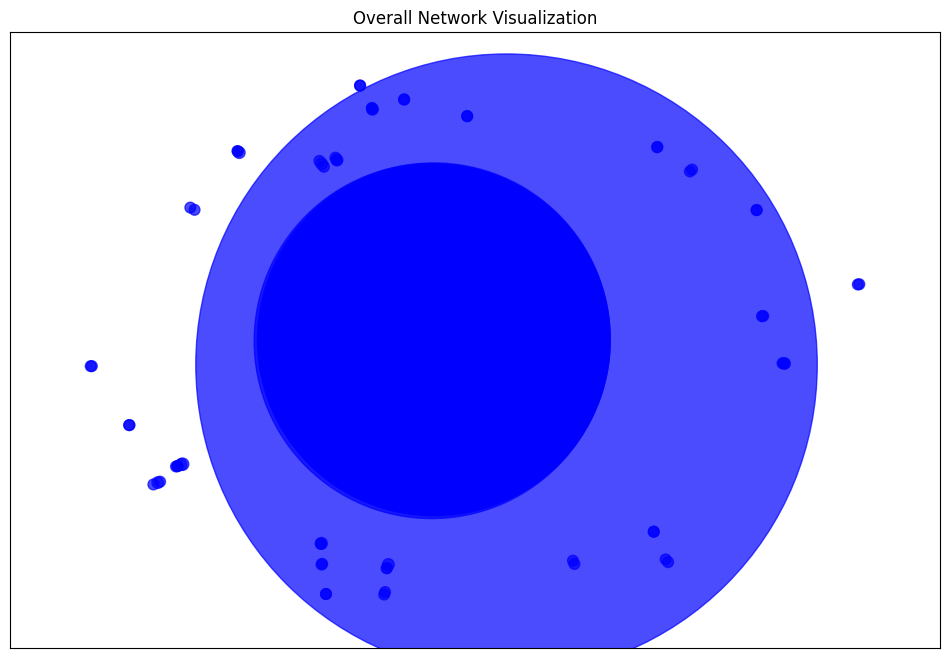

In [6]:
plt.figure(figsize=(12, 8))

pos = nx.kamada_kawai_layout(G)

node_sizes = [10 + 2 * G.degree(n) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

plt.title("Overall Network Visualization")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
    
# Detect communities
communities = greedy_modularity_communities(G)

# Assign a different color to each community
community_colors = plt.cm.get_cmap('tab20', len(communities))

pos = nx.kamada_kawai_layout(G)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(community), 
                           node_color=[community_colors(i)], node_size=50, alpha=0.6)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

plt.title("Network with Communities")
plt.show()

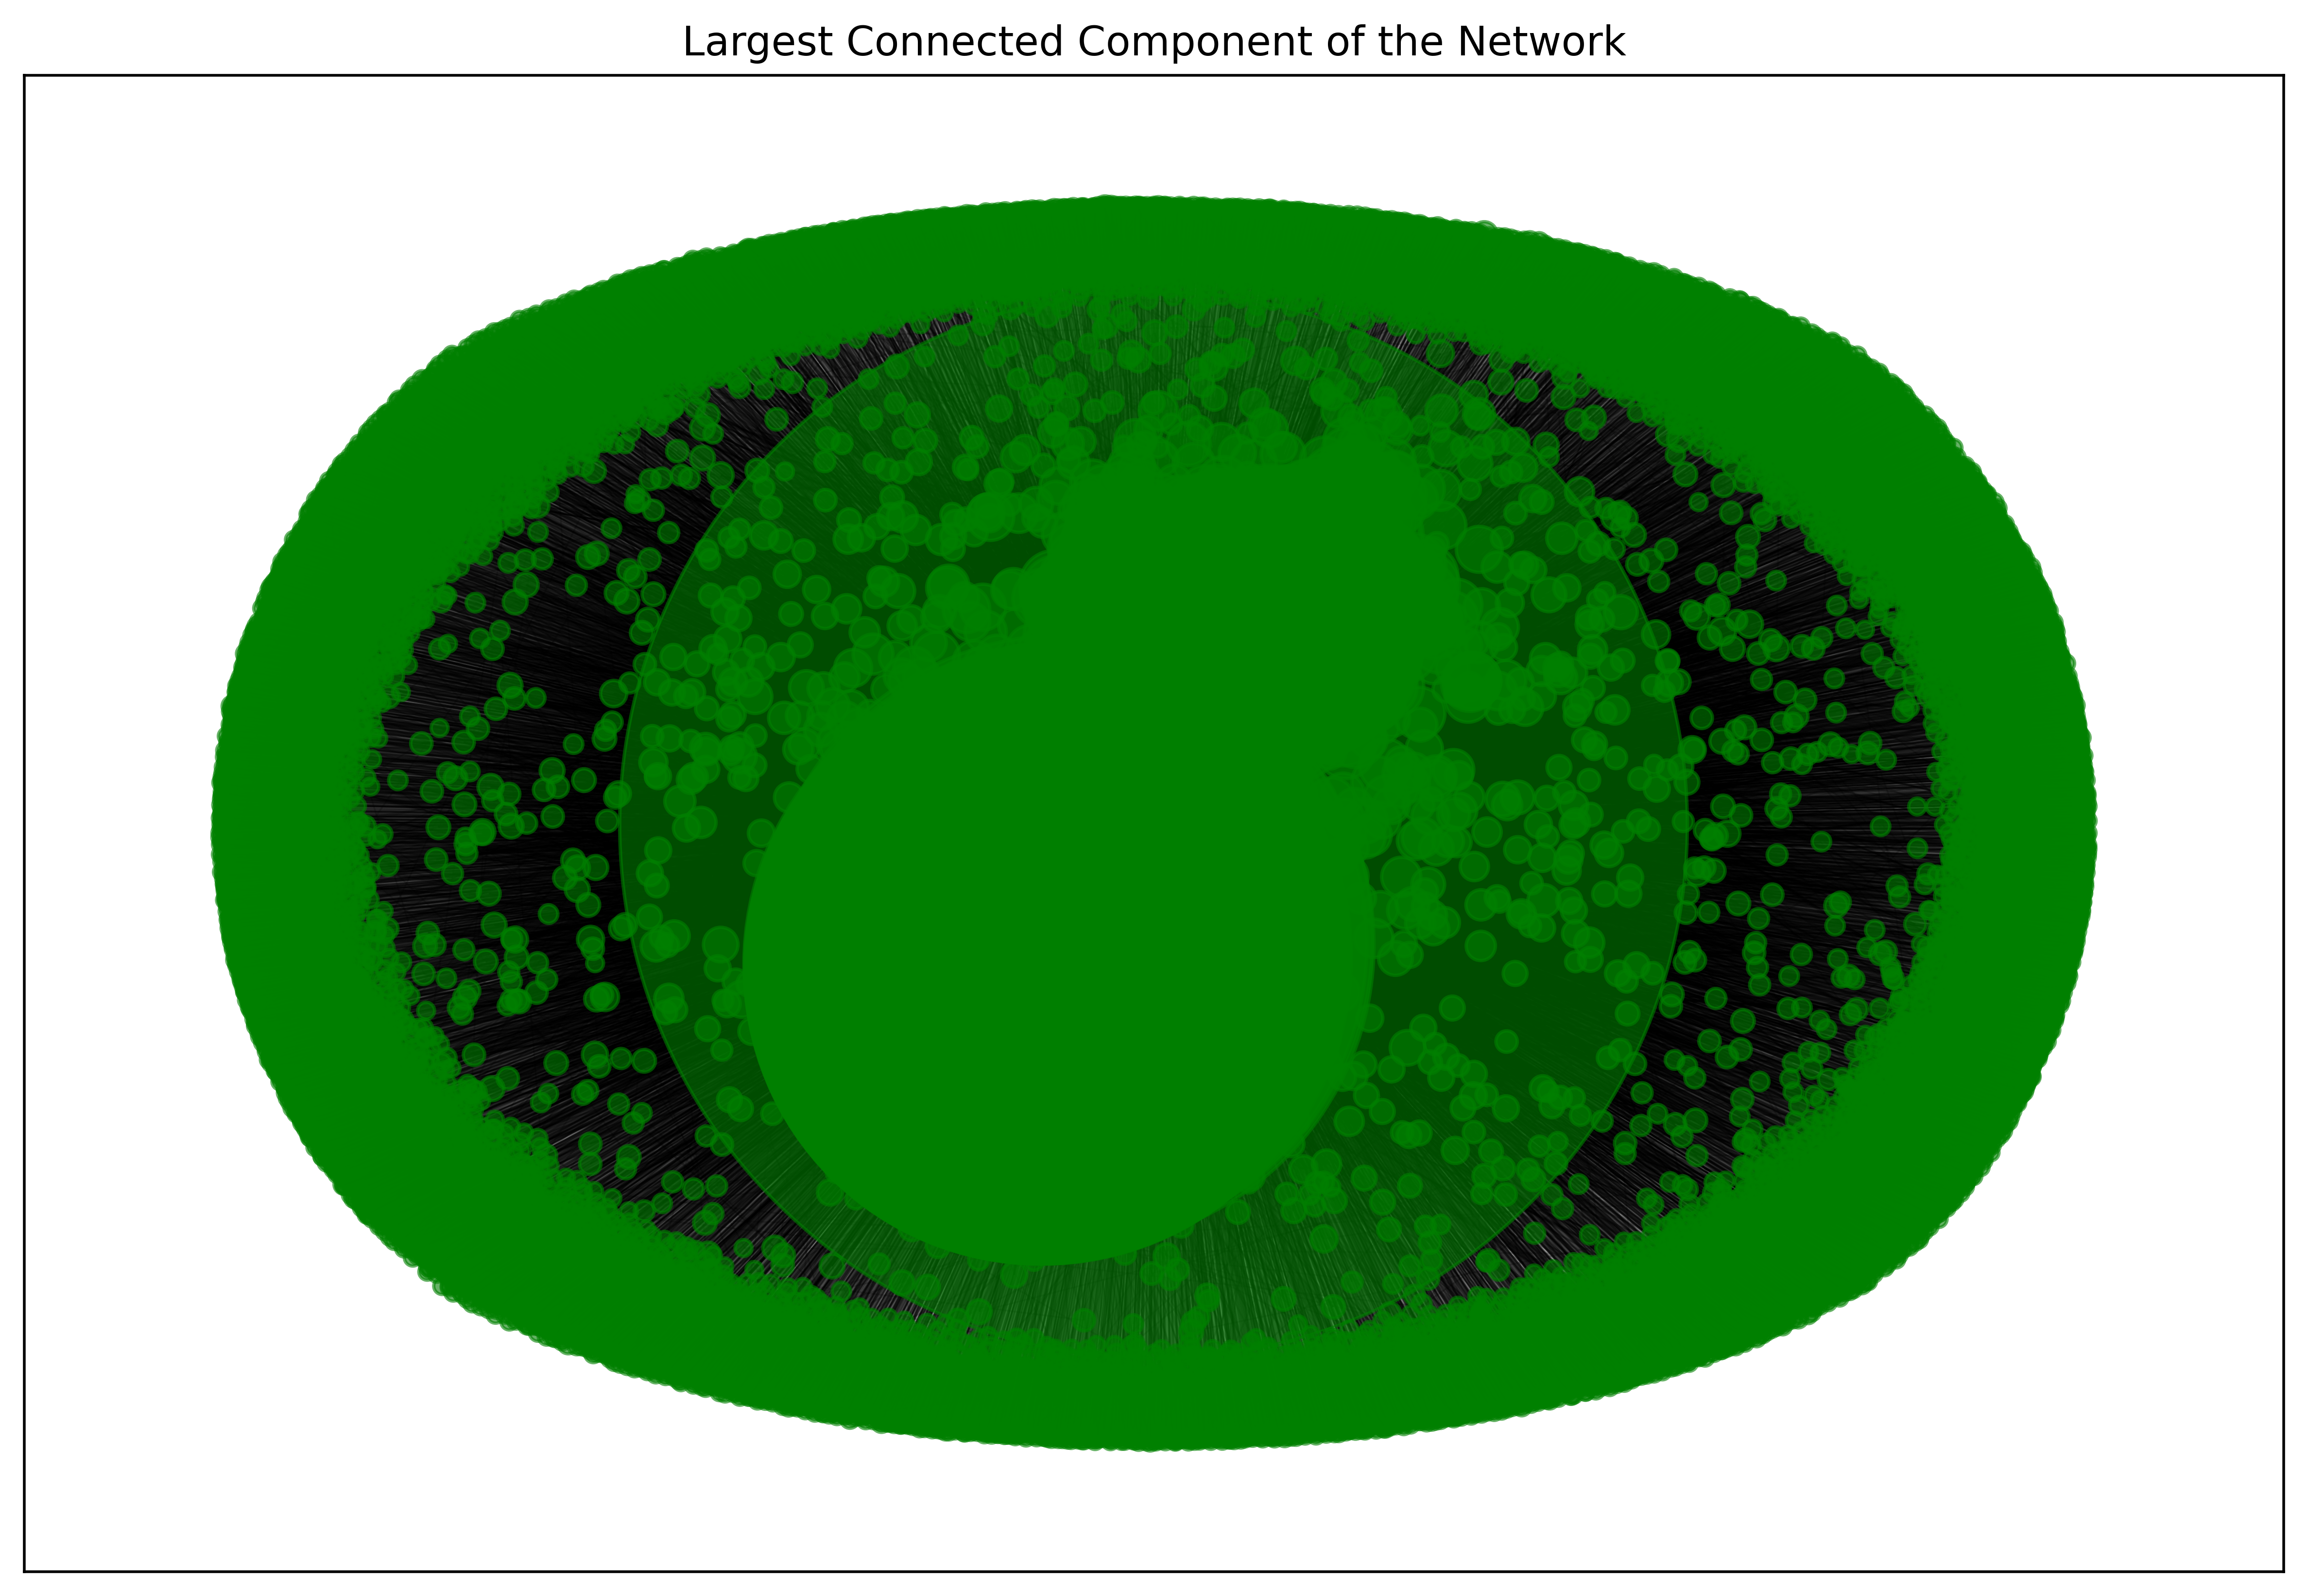

In [7]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

plt.figure(figsize=(12, 8))

pos = graphviz_layout(subgraph, prog='sfdp')

# Further adjust node sizes and transparency
node_sizes = [5 + 2 * subgraph.degree(n) for n in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='green', alpha=0.5)

# Apply edge bundling and reduced edge width
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, width=0.2)

plt.title("Largest Connected Component of the Network")
plt.show()

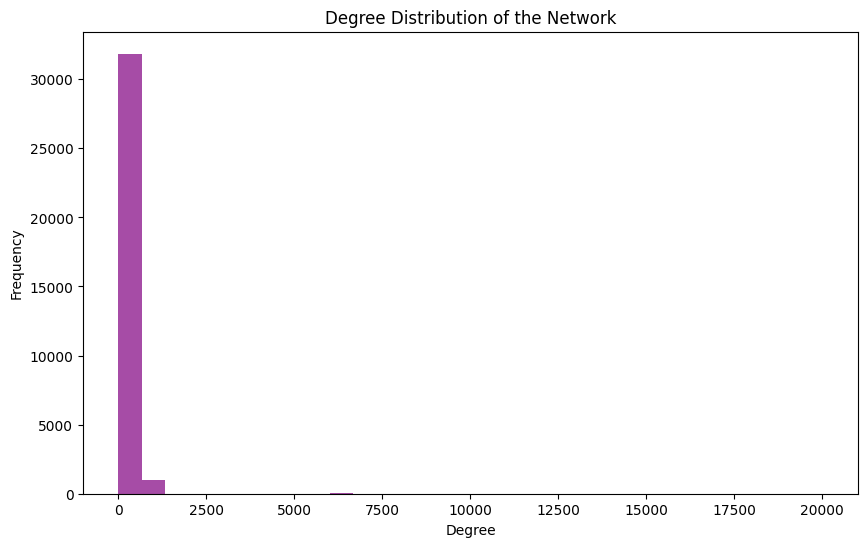

In [8]:
degrees = [G.degree(n) for n in G.nodes()]
    
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, color='purple', alpha=0.7)
plt.title("Degree Distribution of the Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()